In [7]:
%matplotlib notebook
from IPython.display import Image

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [8]:
import os
import h5py
import torch
import numpy as np
from sklearn import decomposition

from orthonet import jacob

### Load Data & Model

In [33]:
BASE_PATH = '/u/xl/tjlane/cryoem/dynanet/particle_simulations/ortho/toys/ellipse/'
MODEL_PATH = BASE_PATH + 'ortho_vae-1.00e+00_ob1.00e+05_db1.00e+00'

#DATA_PATH  = '/u/xl/tjlane/opt/orthonet/toymodels'

In [34]:
# load some data
f = h5py.File(BASE_PATH + '/data.h5','r')
origin = np.array(f['data'])
r      = np.array(f['r'])
theta  = np.array(f['theta'])
f.close()

In [35]:
def load_model(model_path, original_data):

    model = torch.load(model_path + '/model.pt')

    ot = torch.tensor(original_data.astype(np.float32))
    latent = model.encode(ot).detach().numpy()
    recon  = model(ot)

    # deals with VAE case where I also saved logvar, use only mu here
    if type(recon) == tuple:
        recon = recon[0].detach().numpy()
    else:
        recon = recon.detach().numpy()

    return model, latent, recon

model, latent, recon = load_model(MODEL_PATH, origin)
#model.eval()

### Take a look at the training curves and direct latent space

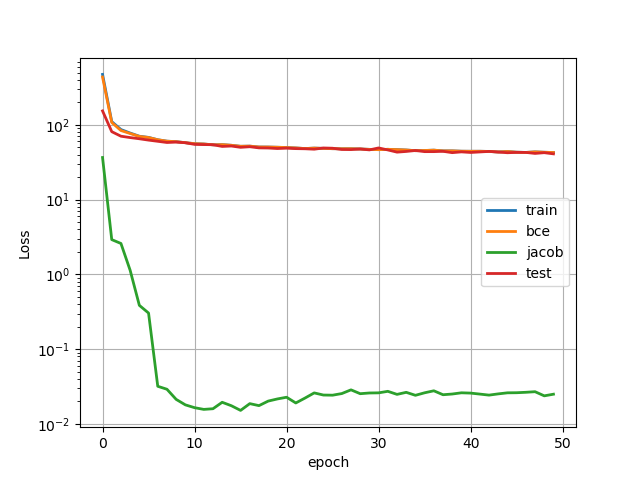

In [36]:
Image(filename=MODEL_PATH + '/loss_curves.png')

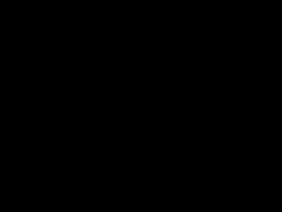

In [37]:
Image(filename=MODEL_PATH + '/z0.png')

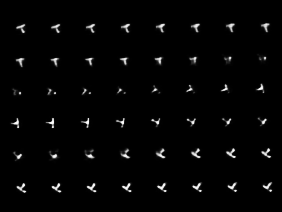

In [38]:
Image(filename=MODEL_PATH + '/z1.png')

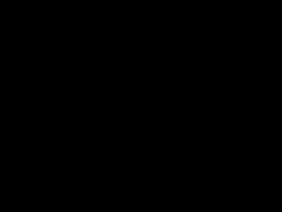

In [39]:
Image(filename=MODEL_PATH + '/z2.png')

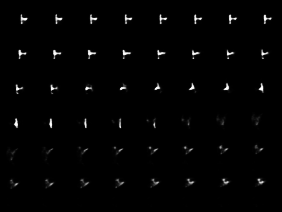

In [40]:
Image(filename=MODEL_PATH + '/z3.png')

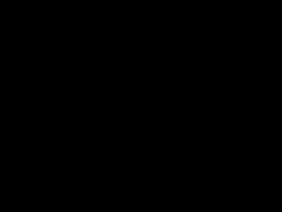

In [41]:
Image(filename=MODEL_PATH + '/z4.png')

### PCA Analysis of Latent Space

<IPython.core.display.Javascript object>


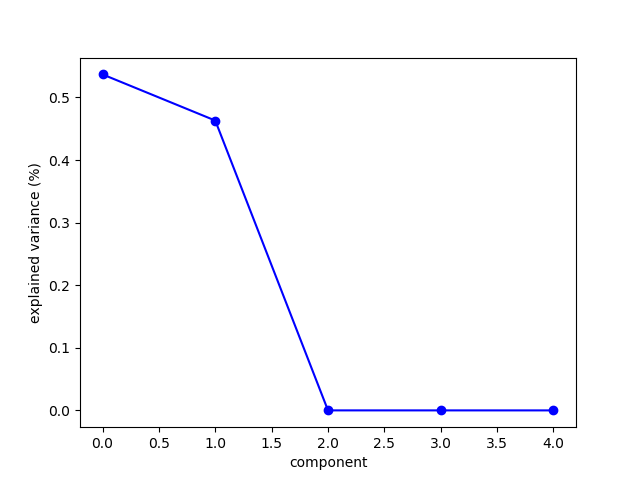

In [42]:
n_components = latent.shape[1]

pca = decomposition.PCA(n_components=n_components)
pca.fit(latent)

plt.figure()
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.plot(pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

In [ ]:
# # trace out the PC space

# model.eval()

# lim = 2 # 2
# res = 0.01 # 0.05
# fps = 60

# #basis = 'pcs'
# basis = 'latent'

# component = 3

# if basis == 'pcs':
#     z = pca.components_[component]
# elif basis == 'latent':
#     z = np.eye(n_components)[component]

# s = np.arange(-lim,lim,res)
# z = np.outer(s, z).astype(np.float32)
# x = torch.tensor(z)
# rx = model.decode(x).detach().numpy()


# fig = plt.figure()
# ax = plt.subplot(111)
# ax.axis('off')
# ims = []
# for ri in rx:
#     ims.append( [plt.imshow(ri, animated=True)] )
# ani = animation.ArtistAnimation(fig, ims, interval=fps, blit=False,
#                                 repeat_delay=0)
# ani.save('/u/xl/tjlane/%s_%d_movie.mp4' % (basis, component), 
#         fps=fps)
# plt.show()

(25000, 5)


<IPython.core.display.Javascript object>


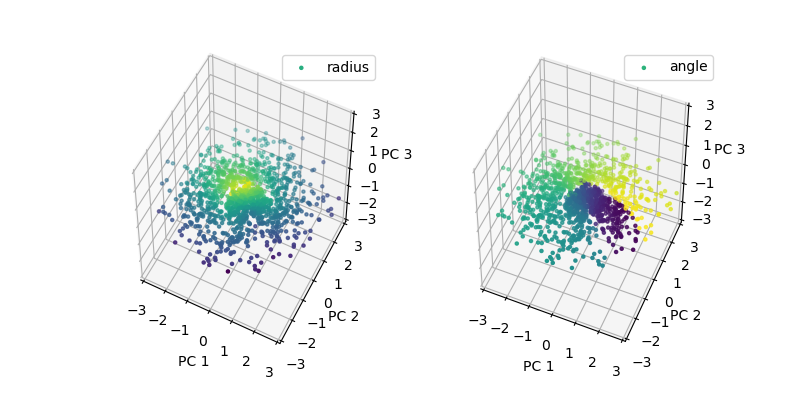

In [43]:
max_pts = 1280
l = 3 # plot limits

latent_in_pc = pca.transform(latent)
print(latent_in_pc.shape)

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121, projection='3d')

ax.scatter(latent_in_pc[:max_pts,0],
           latent_in_pc[:max_pts,1],
           latent_in_pc[:max_pts,2],
           c=r[:max_pts], marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['radius'])

ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])


ax = fig.add_subplot(122, projection='3d')

ax.scatter(latent_in_pc[:max_pts,0],
           latent_in_pc[:max_pts,1],
           latent_in_pc[:max_pts,2],
           c=theta[:max_pts], marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['angle'])

ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])

plt.savefig(MODEL_PATH+'/latent.pdf')
plt.show()

### Direct look at the Jacobian of the resulting network

In [ ]:
n_samples = 128
n_outputs = torch.tensor(np.product(origin.shape[1:]))

J = np.zeros([1089, 5])
for i in range(n_samples):
    Jx = jacob.jacobian(model.decode, torch.tensor(latent[i]), n_outputs)
    J += Jx.detach().numpy()

In [ ]:
J_pca = decomposition.PCA(n_components=J.shape[1])
J_pca.fit(J)

plt.figure()
plt.plot(J_pca.explained_variance_ratio_, 'bo')
plt.plot(J_pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

In [ ]:
JG = np.dot(J.T, J)

plt.figure()
plt.title('Jacobian-Grammian')
plt.imshow(JG)

for (j,i),label in np.ndenumerate(JG):
    plt.text(i, j, np.round(label,3), ha='center', va='center', color='w')
    
plt.show()

### Investigate the effect of parameters on the dimensionality of the latent space

In [20]:
dbeta = 1.0
obetas = [1e4, 2e4, 4e4, 6e4, 8e4, 1e5, 2e5, 4e5, 6e5, 8e5, 1e6]
vbetas = [0.03, 0.1, 0.3, 1.0]

variance_cutoff = 1e-2

n_dimensions = np.zeros((len(vbetas), len(obetas)))

for i,vbeta in enumerate(vbetas):
    for j,obeta in enumerate(obetas):

        model_path = BASE_PATH + 'ortho_vae-%.2e_ob%.2e_db%.2e' % (vbeta, obeta, dbeta)
        
        if os.path.exists(model_path + '/model.pt'):
        
            _, latent, _ = load_model(model_path, origin)
            n_components = latent.shape[1]

            pca = decomposition.PCA(n_components=n_components)
            pca.fit(latent)

            nd = np.sum(pca.explained_variance_ratio_ > variance_cutoff)
            print(obeta, vbeta, pca.explained_variance_ratio_)
            n_dimensions[i,j] = nd

200000.0 0.03 [0.38353795 0.32324147 0.21194531 0.04954368 0.03173158]
400000.0 0.03 [0.42396003 0.27561143 0.24918866 0.05071427 0.00052559]
600000.0 0.03 [0.41834804 0.32556924 0.1889175  0.06153388 0.00563139]
800000.0 0.03 [0.47004047 0.30128652 0.22117937 0.00640008 0.00109359]
1000000.0 0.03 [0.46211523 0.40534586 0.09298499 0.03848821 0.00106573]
200000.0 0.1 [4.5863256e-01 3.0935109e-01 2.3026918e-01 1.5382906e-03 2.0893813e-04]
400000.0 0.1 [4.8700237e-01 4.5421672e-01 5.8152933e-02 5.1773636e-04 1.1020850e-04]
600000.0 0.1 [0.41771173 0.31999066 0.22187793 0.03981479 0.00060488]
800000.0 0.1 [4.42583889e-01 3.67550403e-01 1.13629758e-01 7.61333928e-02
 1.02582766e-04]
1000000.0 0.1 [4.6129593e-01 4.1616809e-01 1.1956532e-01 2.5470450e-03 4.2362363e-04]
10000.0 0.3 [4.7026193e-01 3.1388059e-01 2.1535988e-01 3.4498327e-04 1.5265844e-04]
20000.0 0.3 [4.6849844e-01 3.8874781e-01 1.4253651e-01 1.4375184e-04 7.3520161e-05]
40000.0 0.3 [9.1534257e-01 8.4516019e-02 1.2323778e-04 9.20

<IPython.core.display.Javascript object>


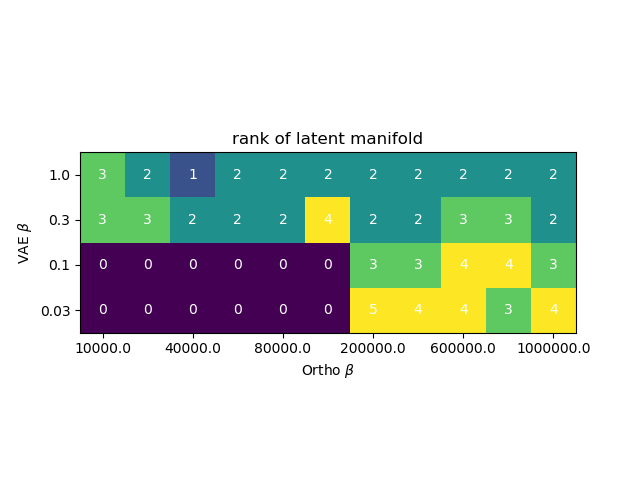

/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


In [21]:
plt.figure()

plt.title('rank of latent manifold')

ax = plt.subplot(111)
ax.imshow(n_dimensions, aspect=1, origin='bottomleft', vmin=0, vmax=4)

#ax.set_yticklabels(['x'] + list(vbetas))
ax.set_yticklabels(['x'] + list(vbetas))
ax.set_xticklabels(['x'] + list(obetas)[::2])
plt.ylabel(r'VAE $\beta$')
plt.xlabel(r'Ortho $\beta$')

for (j,i),label in np.ndenumerate(n_dimensions):
    plt.text(i, j, int(label), ha='center', va='center', color='w')

plt.show()